In [1]:
%matplotlib inline

import librosa
from librosa import display, load
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
#from torchaudio import load
from scipy.signal import fftconvolve

from torchnmf import NMF, NMFD, BetaMu
from torchnmf.metrics import Beta_divergence

# this for playing audio
import IPython.display as ipd

# Speech Signal

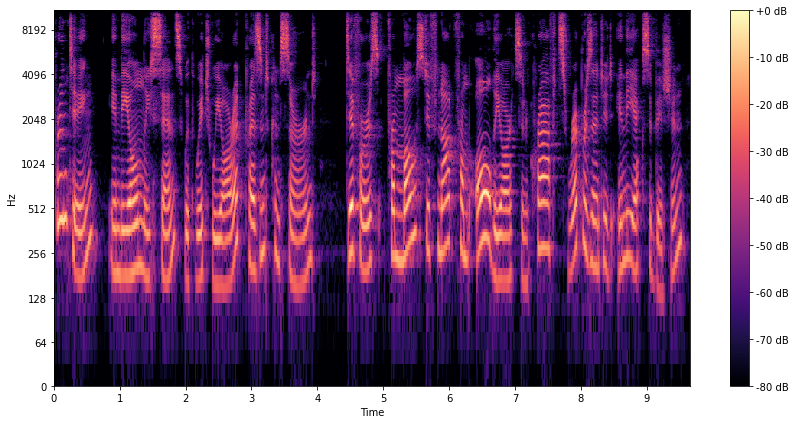

torch.Size([212893]) torch.Size([513, 832]) 22050


In [2]:
y, sr = load('/media/ycy/Shared/Datasets/LJSpeech-1.1/LJSpeech-1.1/wavs/LJ001-0001.wav', sr=None)
y = torch.Tensor(y)#[:sr * 4]

nfft = 1024
hop_length = 256
window = torch.hann_window(nfft)

S = torch.stft(y, nfft, window=window, hop_length=hop_length).pow(2).sum(2).sqrt()

fig = plt.figure(figsize=(12, 6))
display.specshow(librosa.amplitude_to_db(S.numpy(), ref=np.max), y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

print(y.shape, S.shape, sr)

ipd.Audio(y.numpy(), rate=sr)


SourceFilter(
  (source): NMF(
    280, out_channels=513
    (fix_neg): Threshold(threshold=0.0, value=1e-08)
  )
  (filt1): NMF(
    64, out_channels=513
    (fix_neg): Threshold(threshold=0.0, value=1e-08)
  )
  (filt2): NMF(
    10
    (fix_neg): Threshold(threshold=0.0, value=1e-08)
  )
)


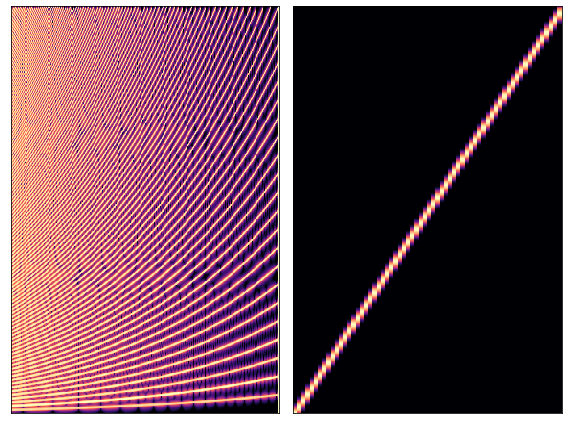

In [3]:
class SourceFilter(nn.Module):
    def __init__(self):
        super().__init__()
        self.Fmin=100
        self.Fmax=500

        
        Ust = 10
        step_size = np.log(2) / 12 / Ust
        self.freqs = np.exp(np.arange(np.log(self.Fmin), np.log(self.Fmax), step_size))
        
        tmp = []
        for f in self.freqs:
            h = np.arange(int(0.5 * sr / f)) + 1
            #h = h[:40]
            ch = f * 27 / 4 * (np.exp(-1j * np.pi * h) + 
                               2 * (1 + 2 * np.exp(-1j * np.pi * h)) / (1j * np.pi * h) - 
                               6 * (1 - np.exp(-1j * np.pi * h)) / (1j * np.pi * h) ** 2)
            ch /= np.abs(ch).max()
            t = np.arange(nfft) / sr
            eu = ch @ np.exp(2j * np.pi * h[:, None] * f * t)
            eu /= np.linalg.norm(eu)
            tmp.append(np.abs(np.fft.fft(eu * window.numpy())[:nfft//2+1]))
        
        noise = np.ones(nfft // 2 + 1)
        tmp.append(noise)
        
        W_f0 = np.vstack(tmp).T
        W_f0 /= W_f0.max(0)
        
        self.source = NMF(S.shape, W=torch.Tensor(W_f0), rank=W_f0.shape[1], trainable_W=False)

        P = 64
        
        hann_size = int(nfft * 0.5 / (P - 1) * 4)
        tmp_hann = torch.hann_window(hann_size)
        
        W_filt = torch.zeros(nfft // 2 + 1 + hann_size // 2 * 2, P)
        for i in range(P):
            pos = int(i / P * (nfft // 2 + 1))
            W_filt[pos:pos+hann_size, i] = tmp_hann
        W_filt = W_filt[hann_size//2:hann_size//2 + nfft // 2 + 1]
        
        K = 10
        
        self.filt1 = NMF(W=torch.Tensor(W_filt), H=(P, K), trainable_W=False)
        self.filt2 = NMF(H=(K, S.shape[1]))

    def forward(self):
        return self.source() * self.filt2(W=self.filt1())


net = SourceFilter()
print(net)

fig = plt.figure(figsize=(8, 6))
plt.subplot(121)
display.specshow(librosa.amplitude_to_db(net.source.W.detach().numpy()))
plt.subplot(122)
display.specshow(net.filt1.W.numpy())
plt.tight_layout()
plt.show()

In [4]:
net.train()
net = net.cuda()
Scu = S.cuda()

maxiter = 200
optim = BetaMu(net.parameters(), beta=1)
for i in range(maxiter):
    def closure():
        return Scu, net()
    net.zero_grad()
    optim.step(closure)
    print(i+1, Beta_divergence(net() + 1e-8, Scu + 1e-8, 1).mul(2).sqrt().item())

1 538.8023681640625
2 507.5107116699219
3 470.6018371582031
4 413.27215576171875
5 352.842529296875
6 318.44921875
7 300.3001708984375
8 287.79937744140625
9 277.5375671386719
10 268.5467834472656
11 260.39849853515625
12 252.7794189453125
13 245.523681640625
14 238.67767333984375
15 232.4442138671875
16 227.02464294433594
17 222.45631408691406
18 218.6156768798828
19 215.34950256347656
20 212.5365447998047
21 210.08970642089844
22 207.94500732421875
23 206.0529327392578
24 204.37457275390625
25 202.8793487548828
26 201.54148864746094
27 200.3385467529297
28 199.25125122070312
29 198.26292419433594
30 197.359130859375
31 196.52806091308594
32 195.75973510742188
33 195.04574584960938
34 194.37954711914062
35 193.75540161132812
36 193.16864013671875
37 192.61521911621094
38 192.09161376953125
39 191.59495544433594
40 191.12266540527344
41 190.67257690429688
42 190.24293518066406
43 189.8320770263672
44 189.438720703125
45 189.06166076660156
46 188.6998291015625
47 188.35214233398438
48 1

(513, 600)


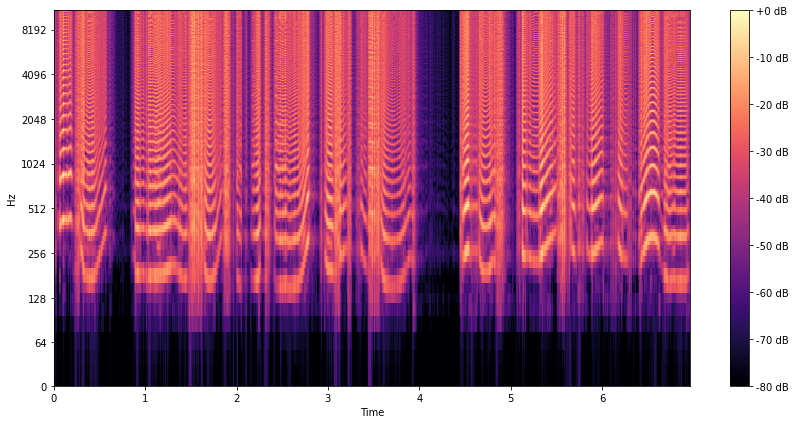

In [6]:
y = net.source().detach().cpu().numpy()[:, :600]
#y = net.impulse.squeeze().detach().cpu().numpy()[:, :200]
#y /= y.max(0)
print(y.shape)

fig = plt.figure(figsize=(12, 6))
display.specshow(librosa.amplitude_to_db(y, ref=np.max), y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()